In [1]:
import MDAnalysis as mda
import numpy as np
import mpl_toolkits.mplot3d as a3
import matplotlib.pyplot as plt
import sys,os
import math
import pandas as pd
from MDAnalysis.analysis import density
from scipy.spatial.distance import cdist
from gridData import Grid
from MDAnalysis.topology.guessers import guess_types
from tqdm import tqdm as tq
import mrcfile
from gridData import mrc
from gridData import OpenDX
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
from scipy.spatial.distance import euclidean
import pylab as pl
from numpy import zeros, ones, arange, asarray, concatenate
import csaps
from matplotlib.pyplot import MultipleLocator
from matplotlib import rc
from MDAnalysis.analysis.rms import RMSF
from sklearn import mixture
import torch
from scipy import spatial
from MDAnalysis.analysis import rms

In [2]:

def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`
    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)
    judge = hull.find_simplex(p) >= 0
    point_index = np.where(judge == True) 
    return point_index

def write_pdb(name, coordinate):
    pdb = open(name, 'w')
    counter = 1
    for i in coordinate:
        pdb.write('ATOM  %5d  C   PTH     1    %8.3f%8.3f%8.3f%6.2f%6.2f\n'%(counter,i[0],i[1],i[2],0.0,0.0))
    return

def tetrahedron_volume(a, b, c, d):
    return np.abs(np.einsum('ij,ij->i', a-d, np.cross(b-d, c-d))) / 6

def convex_hull_volume_bis(pts):
    ch = ConvexHull(pts)

    simplices = np.column_stack((np.repeat(ch.vertices[0], ch.nsimplex),
                                 ch.simplices))
    tets = ch.points[simplices]
    return np.sum(tetrahedron_volume(tets[:, 0], tets[:, 1],
                                     tets[:, 2], tets[:, 3]))


In [3]:
###Define Convex Region and filter out the non-convex grids
u = mda.Universe('trajectory/1jwp_noh.pdb',
                 'trajectory/1jwp_noh.dcd')

###The residues here needs to be adjusted
Convex_region = u.select_atoms('name CA and (resid 236 to 237 or resid 215 to 224 or resid 242 to 245 or resid 268 to 284)')
Convex_region_coordinates = [Convex_region.positions for ts in tq(u.trajectory)]
#Convex_region.write('test.pdb')

density_map_dir = 'water_density_maps_3/'
density_map_files = os.listdir(density_map_dir)
density_map_files.sort(key =lambda x:int(x.split('.')[0]))
Density_map = [Grid(density_map_dir+i).grid for i in density_map_files]
Density_map_1d = [i.ravel() for i in Density_map]

Density_map = Grid('water_density_maps_3/0000.dx')
Delta = Density_map.delta
Origin = Density_map.origin
Density = Density_map.grid
pnts = []
for i in range(Density.shape[0]):
    for j in range(Density.shape[1]):
        for k in range(Density.shape[2]):
            Grid_Coordinate = ((i+1/2)*Delta[0]+Origin[0], (j+1/2)*Delta[1]+Origin[1], (k+1/2)*Delta[2]+Origin[2])
            pnts.append(Grid_Coordinate)
pnts = np.round(pnts, decimals=3)

Points_Inside_Index = []
for i in tq(range(len(Convex_region_coordinates))):
    points = Convex_region_coordinates[i]
    points_inside_index = in_hull(pnts,points)
    Points_Inside_Index.append(points_inside_index)
Points_Inside_Index = [Points_Inside_Index[i][0] for i in range(len(Points_Inside_Index))]

target_protein_atoms = u.select_atoms('protein and (resid 236 to 237 or resid 215 to 224 or resid 242 to 245 or resid 268 to 284)')
target_protein_atoms_coordinates = [target_protein_atoms.positions for ts in tq(u.trajectory)]
    

/usr/local/anaconda3/envs/RCs/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:328: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/usr/local/anaconda3/envs/RCs/lib/python3.8/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [4]:
###Calulate Volume and Convex_Density
Cryptic_Volume = []
Average_density  = []
Convex_Density = []
for i in tq(range(len(Points_Inside_Index))):
    index = np.array(Points_Inside_Index[i])
    points_inside_coordinates = pnts[index]
    dist = cdist(target_protein_atoms_coordinates[i],points_inside_coordinates)
    
    #Get the indices of points to be kept based on distance
    keep_index_list = np.where(np.all(dist >= 1.7, axis=0))[0]
    #Update indices, coordinates, and density map accordingly
    kept_index = index[keep_index_list]
    kept_points_inside_coordinates = pnts[kept_index]
    density_map_1d = Density_map_1d[i]
    convex_density = density_map_1d[kept_index]
    Convex_Density.append(convex_density)
    #write_pdb('/scratch2/users/tq19b/analysis_2024/1jwp_2024_water_analysis_data/raw_pocket/raw_pocket_' + str(i) + '.pdb', kept_points_inside_coordinates)
    
    #keep only points with the density greater or equal to 0.01
    volume_grids_index = np.where(convex_density >= 0.0069)[0]
    volume_grids = kept_index[volume_grids_index]
    #write_pdb('/scratch2/users/tq19b/analysis_2024/1jwp_2024_water_analysis_data/refined_pocket/refined_pocket_' + str(i) + '.pdb', pnts[volume_grids])    
    volume_density = convex_density[volume_grids_index]
    average_volume_density = np.average(volume_density)
    Average_density.append(average_volume_density)
    volume = len(volume_grids) * (2*2*2)
    #if len(volume_grids) < 4:
    #    volume = 0
    #else:
    #    volume = convex_hull_volume_bis(volume_grids)
    Cryptic_Volume.append(volume)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3204/3204 [00:01<00:00, 3104.49it/s]


Text(0.5, 1.0, 'Average_Water_Density_Plot_CBT')

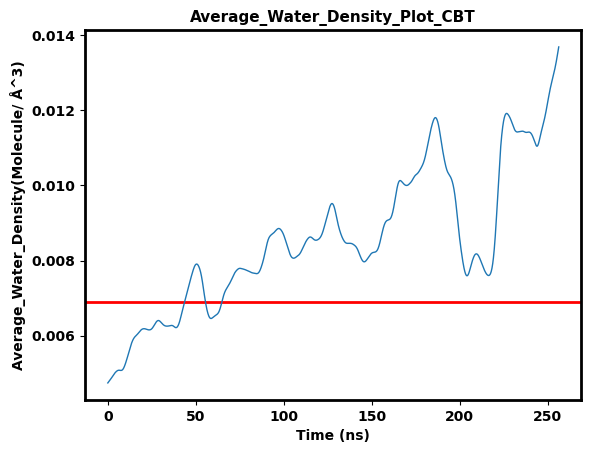

In [5]:
# Function to make plot edges bold
def bold_edges(ax, linewidth=2):
    for spine in ax.spines.values():
        spine.set_linewidth(linewidth)

# Function to set tick labels bold
def set_tick_labels_bold(ax):
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        
Average_Convex_Density = [np.average(i) for i in Convex_Density]
# Plot for dvdl.dat
fig, ax = plt.subplots()
simulation_time = np.arange(len(u.trajectory))
simulation_time = [i * 0.08 for i in simulation_time]
x = simulation_time
y_d = Average_Convex_Density
plt.axhline(y = 0.0069, color = 'red', linewidth = 2)
bold_edges(ax)
spline_d = csaps.CubicSmoothingSpline(x, y_d, smooth=0.01)
y_d_spline = spline_d(x)
ax.plot(x, y_d_spline, linewidth = 1)
ax.set_xlabel('Time (ns)', fontsize=10, fontweight='bold')
ax.set_ylabel('Average_Water_Density(Molecule/ Å^3)', fontsize=10, fontweight='bold')
set_tick_labels_bold(ax)
ax.set_title('Average_Water_Density_Plot_CBT', fontsize=11, fontweight='bold')
#plt.savefig('/home/tq19b/data_analysis/1jwp_figs/Averate_Water_Density_Plot.png')


Text(0.5, 1.0, 'Cryptic_Site_Volume_Fluctuation_CrypWater_CBT')

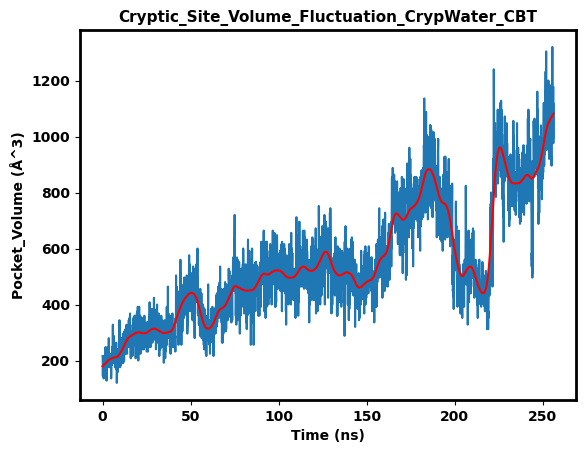

In [6]:
Cryptic_Volume = np.round(Cryptic_Volume, decimals=3)
# Plot for dvdl.dat
fig, ax = plt.subplots()
simulation_time = np.arange(len(u.trajectory))
simulation_time = [i * 0.08 for i in simulation_time]
x = simulation_time
y_d = Cryptic_Volume
bold_edges(ax)
spline_d = csaps.CubicSmoothingSpline(x, y_d, smooth=0.01)
y_d_spline = spline_d(x)
ax.plot(x, y_d)
ax.plot(x, y_d_spline, color = 'red')
ax.set_xlabel('Time (ns)', fontsize=10, fontweight='bold')
ax.set_ylabel('Pocket_Volume (Å^3)', fontsize=10, fontweight='bold')
set_tick_labels_bold(ax)
ax.set_title('Cryptic_Site_Volume_Fluctuation_CrypWater_CBT', fontsize=11, fontweight='bold')
#plt.savefig('/home/tq19b/data_analysis/1jwp_figs/Cryptic_Site_Volume_Plot.png')

